In [216]:
import numpy as np
import random
import matplotlib.pyplot as plt
import xgboost as xgb

In [217]:
# Payoffs
payoff_matrix = {
    ('C', 'C'): (3, 3),
    ('C', 'D'): (0, 5),
    ('D', 'C'): (5, 0),
    ('D', 'D'): (1, 1)
}

def random_strategy(history, player):
    """Always picks C or D at random."""
    return random.choice(['C','D'])

def tit_for_tat(history, player):
    """
    Cooperate on first move; thereafter mirror opponent's last move.
    history is list of tuples [(p1_move, p2_move), ...].
    player is 1 or 2.
    """
    if not history:
        return 'C'
    last = history[-1]
    last_move = ""
    if player == 1:
        last_move = last[1]
    elif player == 2:
        last_move = last[0]
    return "D" if last_move == "D" else "C"

# --- Always Cooperate ---
def always_cooperate(history, player):
    return 'C'

# --- Always Defect ---
def always_defect(history, player):
    return 'D'

# --- Grim Trigger ---
def grim_trigger(history, player):
    if not history:
        return 'C'
    opp_defected = any(
        (h[1]=='D' if player==1 else h[0]=='D')
        for h in history
    )
    return 'D' if opp_defected else 'C'


def tit_for_two_tats(history, player):
    if len(history) < 2:
        return 'C'
    last_two = history[-2:]
    opp_moves = [(h[1] if player==1 else h[0]) for h in last_two]
    return 'D' if all(m=='D' for m in opp_moves) else 'C'


def pavlov(history, player):
    """
    If last round got high payoff (3 or 5), repeat your last action; otherwise switch.
    """
    if not history:
        return 'C'
    last = history[-1]
    payoff_p1, payoff_p2 = payoff_matrix[(last[0], last[1])]
    payoff = payoff_p1 if player==1 else payoff_p2
    last_action = last[0] if player==1 else last[1]
    if payoff >= 3:
        return last_action
    return 'C' if last_action=='D' else 'D'


def generous_tit_for_tat(history, player, generosity=0.3):
    """
    Like tit-for-tat, but with a chance to forgive (cooperate) even if opponent defected.
    generosity = probability of forgiving.
    """
    if not history:
        return 'C'
    opp_last = history[-1][1] if player==1 else history[-1][0]
    if opp_last == 'C':
        return 'C'
    return 'C' if random.random() < generosity else 'D'


def soft_majority(history, player):
    """
    Cooperate if opponent has cooperated more often than defected so far; else defect.
    """
    if not history:
        return 'C'
    opp_moves = [h[1] if player==1 else h[0] for h in history]
    coop = opp_moves.count('C')
    defect = opp_moves.count('D')
    return 'C' if coop >= defect else 'D'

# --- 1. Alternator ---
def alternator(history, player):
    """
    Cooperate on odd‐numbered rounds, defect on even‐numbered rounds.
    """
    round_num = len(history) + 1
    return 'C' if round_num % 2 == 1 else 'D'


# --- 2. Suspicious Tit‑for‑Tat ---
def suspicious_tit_for_tat(history, player):
    """
    Defect on the first move, then play Tit‑for‑Tat.
    """
    if not history:
        return 'D'
    
    last = history[-1][1] if player == 1 else history[-1][0]
    return last


# --- 3. Tester ---
def tester(history, player):
    """
    Round1: Defect  
    Round2: Cooperate  
    Thereafter: Tit‑for‑Tat
    """
    if len(history) == 0:
        return 'D'
    if len(history) == 1:
        return 'C'
    last = history[-1][1] if player == 1 else history[-1][0]
    return last


# --- 4. Limited Retaliation ---
def limited_retaliation(history, player, m=2):
    """
    Cooperate until opponent defects; then defect for m rounds, then forgive.
    """
    if not history:
        return 'C'
    # extract opponent’s moves
    opp = [h[1] if player == 1 else h[0] for h in history]
    # find index of last defection
    defections = [i for i, move in enumerate(opp) if move == 'D']
    if not defections:
        return 'C'
    last_def = defections[-1]
    # soon after that defection, we punish for m rounds
    current = len(history)
    if current <= last_def + m:
        return 'D'
    return 'C'


# --- 5. Gradual (simplified) ---
def gradual(history, player):
    """
    For each opponent defection, punish with two defections, then two cooperations.
    This simplified version uses total # of opponent defections to enter a 4‐round cycle.
    """
    # count opponent defections
    opp = [h[1] if player == 1 else h[0] for h in history]
    d_count = opp.count('D')
    # cycle through: D, D, C, C
    phase = d_count % 6
    return 'D' if phase in (0, 1) else 'C'


def simulate_game(rounds, strat1, strat2):
    history = []
    for r in range(1, rounds+1):
        a1 = strat1(history, 1)
        a2 = strat2(history, 2)
        p1, p2 = payoff_matrix[(a1,a2)]
        history.append([r,a1, a2,p1,p2])

    total1 = sum(h[3] for h in history)
    total2 = sum(h[4] for h in history)
    
    if total1 > total2:
        winner = 1
    elif total2 > total1:
        winner = 2
    else:
        winner = 0

    return history, {'p1_total': total1, 'p2_total': total2}, winner

In [211]:
STRATEGIES = {
    'Tit-for-Tat': tit_for_tat,
    'Tit-for-2-Tat': tit_for_two_tats,
    "Suspicious-Tit-for-Tat": suspicious_tit_for_tat,
    'Grim Trigger': grim_trigger,
    'Pavlov': pavlov,
    'Always Cooperate': always_cooperate,
    'Generous TFT': generous_tit_for_tat,
    'Soft Majority': soft_majority,
    'Random Strategy': random_strategy,
    'Alternator': alternator,
    'Gradual': gradual,
    "Limited Retaliation": limited_retaliation,
    "Tester": tester,
}

def generate_strategy_dataset(strategies, seq_len=10, games_per_strat=500):
    pair2id = {('C','C'):0, ('C','D'):1, ('D','C'):2, ('D','D'):3}
    X, y = [], []
    rowid = 0
    for label, strat in enumerate(strategies.values()):
        for _ in range(games_per_strat):
            history = []
            # simulate seq_len rounds
            rand = random.choice(list(strategies.items()))[1]
            for _ in range(seq_len):
                a1 = strat(history, 1)
                a2 = random_strategy(history, 2) # rand(history, 2)
                p1, p2 = payoff_matrix[(a1,a2)]
                history.append((a1,a2))
                rowid += 1
            # encode the last seq_len pairs
            tokens = [pair2id[p] for p in history]
            X.append(tokens)
            y.append(list(STRATEGIES.keys())[label])
    return np.array(X), np.array(y)

X, y = generate_strategy_dataset(STRATEGIES, seq_len=25, games_per_strat=5000)
print("X shape:", X.shape, "y shape:", y.shape)

X shape: (65000, 10) y shape: (65000,)


In [212]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)

le = LabelEncoder()

y_train_encoded = le.fit_transform(y_train)
y_val_encoded = le.transform(y_val)
y_test_encoded = le.transform(y_test)

# Train
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Evaluate
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred,
      target_names=list(STRATEGIES.keys())))

                        precision    recall  f1-score   support

           Tit-for-Tat       0.99      1.00      0.99      1000
         Tit-for-2-Tat       0.84      0.82      0.83      1000
Suspicious-Tit-for-Tat       0.76      0.60      0.67      1000
          Grim Trigger       0.98      1.00      0.99      1000
                Pavlov       0.80      0.79      0.79      1000
      Always Cooperate       0.82      0.85      0.83      1000
          Generous TFT       0.95      0.98      0.96      1000
         Soft Majority       0.99      0.84      0.91      1000
       Random Strategy       0.71      0.74      0.73      1000
            Alternator       0.75      0.74      0.75      1000
               Gradual       0.74      0.76      0.75      1000
   Limited Retaliation       0.83      0.88      0.85      1000
                Tester       0.75      0.88      0.81      1000

              accuracy                           0.84     13000
             macro avg       0.84     

In [213]:
clf = xgb.XGBClassifier(
    objective='multi:softmax',
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    random_state=1122,
    eval_metric='mlogloss',
    early_stopping_rounds=5,
    n_jobs=-1
)

clf.fit(X_train, y_train_encoded, eval_set=[(X_train, y_train_encoded), (X_val, y_val_encoded)])


# Evaluate
y_pred = le.inverse_transform(clf.predict(X_test))
print(classification_report(y_test, y_pred,
      target_names=list(STRATEGIES.keys())))

[0]	validation_0-mlogloss:2.39676	validation_1-mlogloss:2.39505
[1]	validation_0-mlogloss:2.27216	validation_1-mlogloss:2.26892
[2]	validation_0-mlogloss:2.16541	validation_1-mlogloss:2.16224
[3]	validation_0-mlogloss:2.07717	validation_1-mlogloss:2.07394
[4]	validation_0-mlogloss:1.99597	validation_1-mlogloss:1.99250
[5]	validation_0-mlogloss:1.92391	validation_1-mlogloss:1.92077
[6]	validation_0-mlogloss:1.86240	validation_1-mlogloss:1.85912
[7]	validation_0-mlogloss:1.80483	validation_1-mlogloss:1.80155
[8]	validation_0-mlogloss:1.75289	validation_1-mlogloss:1.74962
[9]	validation_0-mlogloss:1.70562	validation_1-mlogloss:1.70239
[10]	validation_0-mlogloss:1.66236	validation_1-mlogloss:1.65975
[11]	validation_0-mlogloss:1.62408	validation_1-mlogloss:1.62144
[12]	validation_0-mlogloss:1.58689	validation_1-mlogloss:1.58460
[13]	validation_0-mlogloss:1.55338	validation_1-mlogloss:1.55112
[14]	validation_0-mlogloss:1.52226	validation_1-mlogloss:1.52024
[15]	validation_0-mlogloss:1.49338	

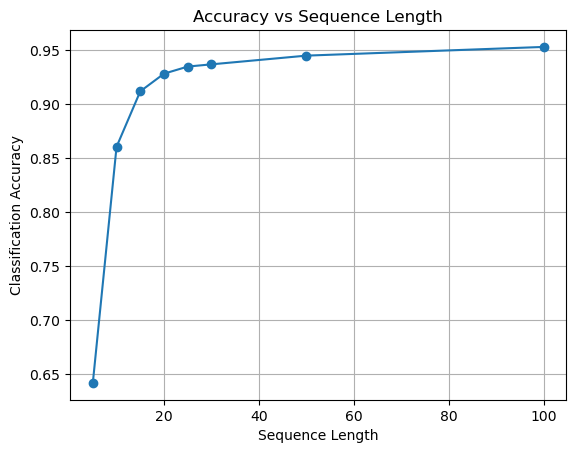

In [92]:
sequence_lengths = [5, 10, 15, 20, 25, 30, 50, 100]
accuracies = []

for L in sequence_lengths:
    X, y = generate_strategy_dataset(STRATEGIES, seq_len=L, games_per_strat=5000)
    
    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2)
    
    le = LabelEncoder()
    
    y_train_encoded = le.fit_transform(y_train)
    y_val_encoded = le.transform(y_val)
    y_test_encoded = le.transform(y_test)
    
    clf.fit(X_train, y_train_encoded, eval_set=[(X_train, y_train_encoded), (X_val, y_val_encoded)], verbose=False)
    acc = clf.score(X_test, y_test_encoded)
    accuracies.append(acc)

plt.figure()
plt.plot(sequence_lengths, accuracies, marker='o')
plt.xlabel('Sequence Length')
plt.ylabel('Classification Accuracy')
plt.title('Accuracy vs Sequence Length')
plt.grid(True)
plt.show()

In [52]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras import Model
from sklearn.preprocessing import LabelEncoder

num_strats = len(STRATEGIES)
seq_len = X.shape[1]
vocab_size = 4  # four possible (p1,p2) pairs

# build model
inp = Input(shape=(seq_len,), dtype="int32")
x = Embedding(vocab_size, 16, input_length=seq_len)(inp)
x = LSTM(4, return_sequences=False)(x)
x = Dropout(0.2)(x)
out = Dense(num_strats, activation="softmax")(x)
model = Model(inp, out)

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

le = LabelEncoder()
le.fit(y_train)

y_train_cat = le.transform(y_train)

# train
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.1,
    epochs=30, batch_size=128
)


y_test_cat = le.transform(y_test)
# evaluate
loss, acc = model.evaluate(X_test, y_test_cat, verbose=0)
y_pred_cat = model.predict(X_test).argmax(axis=-1)
print(f"LSTM test accuracy: {acc:.3f}")

Epoch 1/30
315/315 [==============================] - 1s 2ms/step - loss: 2.4413 - accuracy: 0.1658 - val_loss: 2.1570 - val_accuracy: 0.2949
Epoch 2/30
315/315 [==============================] - 0s 1ms/step - loss: 2.0004 - accuracy: 0.3130 - val_loss: 1.7378 - val_accuracy: 0.4498
Epoch 3/30
315/315 [==============================] - 0s 1ms/step - loss: 1.7382 - accuracy: 0.3776 - val_loss: 1.5530 - val_accuracy: 0.4752
Epoch 4/30
315/315 [==============================] - 0s 1ms/step - loss: 1.6396 - accuracy: 0.3921 - val_loss: 1.4702 - val_accuracy: 0.5020
Epoch 5/30
315/315 [==============================] - 0s 1ms/step - loss: 1.5875 - accuracy: 0.3977 - val_loss: 1.4145 - val_accuracy: 0.5156
Epoch 6/30
315/315 [==============================] - 0s 1ms/step - loss: 1.5546 - accuracy: 0.4098 - val_loss: 1.3756 - val_accuracy: 0.5156
Epoch 7/30
315/315 [==============================] - 0s 1ms/step - loss: 1.5277 - accuracy: 0.4157 - val_loss: 1.3479 - val_accuracy: 0.5243
Epoch 

In [53]:
y_test_stat = le.inverse_transform(y_test_cat)
y_test_pred_stat = le.inverse_transform(y_pred_cat)
print(classification_report(y_test_pred_stat, y_test_stat, target_names=list(STRATEGIES.keys())))

                        precision    recall  f1-score   support

           Tit-for-Tat       1.00      0.90      0.95      1114
         Tit-for-2-Tat       0.99      0.40      0.57      2490
Suspicious-Tit-for-Tat       1.00      0.99      0.99      1015
          Grim Trigger       0.10      0.40      0.16       255
                Pavlov       0.96      0.93      0.95      1037
         Always Defect       0.81      0.79      0.80      1024
      Always Cooperate       0.62      0.52      0.57      1192
          Generous TFT       0.23      0.27      0.25       848
         Soft Majority       0.03      0.80      0.06        40
       Random Strategy       0.05      0.69      0.09        74
            Alternator       0.79      0.40      0.53      1965
               Gradual       0.24      0.43      0.31       557
   Limited Retaliation       0.24      0.41      0.30       584
                Tester       0.62      0.34      0.44      1805

              accuracy                

In [95]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional

def build_model(hp):
    
    seq_len, num_classes = 50, 16
    
    model = Sequential()
    
    # Embedding dim
    model.add(Embedding(
        input_dim=vocab_size,
        output_dim=hp.Int('embed_dim', 8, 64, step=8),
        input_length=seq_len
    ))
    
    # Number of LSTM layers
    for i in range(hp.Int('num_layers', 1, 3)):
        return_seq = (i < hp.get('num_layers')-1)
        model.add(Bidirectional(
            LSTM(
                units=hp.Int(f'units_{i}', 16, 128, step=16),
                dropout=hp.Float(f'dropout_{i}', 0.0, 0.5, step=0.1),
                recurrent_dropout=hp.Float(f'rec_dropout_{i}', 0.0, 0.5, step=0.1),
                return_sequences=return_seq
            )
        ))
        
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(
        optimizer=hp.Choice('optimizer', ['adam','rmsprop']),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='tuner_dir',
    project_name='50seq_strategy'
)

tuner.search(
    X_train, y_train_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=5,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# Retrieve best hyperparameters
best_hp = tuner.get_best_hyperparameters(1)[0]
print(best_hp.values)

Trial 5 Complete [00h 14m 42s]
val_accuracy: 0.9508035778999329

Best val_accuracy So Far: 0.9509821534156799
Total elapsed time: 01h 00m 36s
{'embed_dim': 24, 'num_layers': 3, 'units_0': 96, 'dropout_0': 0.30000000000000004, 'rec_dropout_0': 0.30000000000000004, 'optimizer': 'rmsprop', 'units_1': 48, 'dropout_1': 0.4, 'rec_dropout_1': 0.4, 'units_2': 16, 'dropout_2': 0.0, 'rec_dropout_2': 0.0}


In [96]:
best_model = tuner.get_best_models(1)[0]
y_test_cat = le.transform(y_test)
# evaluate
loss, acc = best_model.evaluate(X_test, y_test_cat, verbose=0)
y_pred_cat = best_model.predict(X_test).argmax(axis=-1)
print(f"LSTM test accuracy: {acc:.3f}")
y_test_stat = le.inverse_transform(y_test_cat)
y_test_pred_stat = le.inverse_transform(y_pred_cat)
print(classification_report(y_test_pred_stat, y_test_stat, target_names=list(STRATEGIES.keys())))

438/438 [==============================] - 25s 55ms/step
LSTM test accuracy: 0.952
                        precision    recall  f1-score   support

           Tit-for-Tat       1.00      1.00      1.00      1000
         Tit-for-2-Tat       0.98      0.92      0.95      1065
Suspicious-Tit-for-Tat       1.00      1.00      1.00      1000
          Grim Trigger       0.99      1.00      1.00       995
                Pavlov       1.00      1.00      1.00      1001
         Always Defect       0.99      0.95      0.97      1040
      Always Cooperate       1.00      1.00      1.00      1001
          Generous TFT       1.00      1.00      1.00      1001
         Soft Majority       1.00      1.00      1.00       997
       Random Strategy       0.86      0.96      0.91       895
            Alternator       0.51      1.00      0.67       506
               Gradual       1.00      0.67      0.80      1494
   Limited Retaliation       1.00      1.00      1.00      1001
                Test

## Adaptive Strategy

In [119]:
# Example RESPONSE_MAP: customize with your own best responses
RESPONSE_MAP = {
    'Random': always_defect,
    'Tit-for-Tat': always_cooperate,
    'Always Cooperate': always_defect,
    'Always Defect': suspicious_tit_for_tat,
    'Grim Trigger': tit_for_tat,
    'Tit-for-Two-Tats': alternator,
    'Pavlov': tit_for_tat,
    'Generous TFT': alternator,
    'Soft Majority': alternator,
    'Alternator': always_defect,
    'Suspicious TFT': always_cooperate,
    'Tester': always_cooperate,
    'Limited Retaliation': tit_for_tat,
    'Gradual': always_defect
}

# map each (P1,P2) pair to a token 0–3
pair2id = {('C','C'):0, ('C','D'):1, ('D','C'):2, ('D','D'):3}

def adaptive_strategy(history, player):
    """
    1) Once we have at least SEQ_LEN rounds, use clf to predict the opponent's strategy.
    2) Look up the counter‐strategy in RESPONSE_MAP.
    3) Delegate to that counter‐strategy for this move.
    """
    # 1. Not enough history: use a safe default
    SEQ_LEN = 50
    
    if len(history) < SEQ_LEN:
        return random_strategy(history, player)

    # 2. Encode last SEQ_LEN moves into token sequence
    window = history[-SEQ_LEN:]
    tokens = [pair2id[(a1, a2)] for (a1, a2) in window]
    X = np.array([tokens])  # shape (1, SEQ_LEN)

   # 3. Predict the opponent’s strategy index
    if hasattr(clf, "predict_proba"):
        # sklearn classifier
        pred_idx = clf.predict(X)[0]            # scalar
    else:
        # Keras model returning softmax
        probs    = clf.predict(X)                # shape (1, n_classes)
        pred_idx = int(probs[0].argmax())        # now a Python int

    # 4. Inverse‐map to the string name
    opp_name = le.inverse_transform([pred_idx])[0]

    # 5. Lookup counter‐strategy
    counter = RESPONSE_MAP.get(opp_name, random_strategy)
    return counter(history, player)

In [231]:
import numpy as np
import random
from sklearn.metrics import accuracy_score

# Payoffs (not used in feature generation, but just for completeness)
PAYOFFS = {
    ('C','C'):(3,3), ('C','D'):(0,5),
    ('D','C'):(5,0), ('D','D'):(1,1)
}

STRATEGIES = {
    'Tit-for-Tat': tit_for_tat,
    'Always Cooperate': always_cooperate,
    'Grim Trigger': grim_trigger,
    'Tit-for-Two-Tats': tit_for_two_tats,
    'Pavlov': pavlov,
    'Generous TFT': generous_tit_for_tat,
    'Soft Majority': soft_majority,
    'Alternator': alternator,
    'Suspicious TFT': suspicious_tit_for_tat,
    'Tester': tester,
    'Limited Retaliation': limited_retaliation,
    'Gradual': gradual
}

# Example strategy for Player 1
def tit_for_tat(history, player):
    if not history:
        return 'C'
    return history[-1][1] if player == 1 else history[-1][0]

pair2id = {('C','C'):0, ('C','D'):1, ('D','C'):2, ('D','D'):3}

def make_move_data(strat, seq_len=10, n_games=5000):
    """
    Builds a dataset (X, y) where:
      - X: shape (n_games, seq_len*2) binary features for the last seq_len rounds
      - y: shape (n_games,)  next opponent move (0 for C, 1 for D)
    """
    X, y = [], []
    for _ in range(n_games):
        history = []
        # simulate seq_len+1 rounds
        for _ in range(seq_len + 1):
            a1 = strat(history, 1)
            # opponent is random here; you can swap in any strategy
            a2 = tit_for_tat(history, 2)
            history.append((a1, a2))
        # build features from the first seq_len rounds
        window = history[:seq_len]
        feats = []
        for p1, p2 in window:
            feats.append(1 if p1 == 'D' else 0)
            feats.append(1 if p2 == 'D' else 0)
        # label is the opponent's move in the (seq_len+1)th round
        next_opp_move = history[seq_len][1]
        X.append(feats)
        y.append(1 if next_opp_move == 'D' else 0)

    return np.array(X), np.array(y)

# build dataset
L = 50
X, y = [], []
for key, strategy in STRATEGIES.items():
    print("Generating data for", key)
    X_temp, y_temp = make_move_data(strategy, seq_len=L, n_games=2000)
    X.append(X_temp)
    y.append(y_temp)

X = np.concatenate(X, axis=0)   # shape: (n_strats * 2000, L*2)
y = np.concatenate(y, axis=0)   # shape: (n_strats * 2000,)

# train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

clf = xgb.XGBClassifier(
    objective='binary:logistic',
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=3,
    random_state=1122,
    eval_metric='logloss',
    early_stopping_rounds=10,
    n_jobs=-1
)
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

# eval
y_pred = clf.predict(X_test)
print("Next‐move accuracy:", accuracy_score(y_test, y_pred))

# --- 3) Play against random using this predictor ---
def policy(history, player):
    # extract last L moves (pad with all-C if needed)
    hist = history[-L:] if len(history)>=L else [('C','C')]* (L-len(history)) + history
    feat = []
    for p1,p2 in hist:
        feat.extend([1 if p1=='D' else 0, 1 if p2=='D' else 0])
    prob_defect = clf.predict_proba([feat])[0][1]
    return 'C' if prob_defect > 0.5 else 'D'

payoffs = {('C','C'):(3,3),('C','D'):(0,5),('D','C'):(5,0),('D','D'):(1,1)}
for key, strategy in STRATEGIES.items():
    history = []
    score_p1 = 0
    score_p2 = 0
    for _ in range(10):
        a1 = policy(history, 1)
        a2 = strategy(history, 2)
        r1,r2 = payoffs[(a1,a2)]
        score_p1 += r1
        score_p2 += r2
        history.append((a1,a2))
    print(f"Total points vs {key}:", score_p1)
    print("enemy score:", score_p2)


Generating data for Tit-for-Tat
Generating data for Always Cooperate
Generating data for Grim Trigger
Generating data for Tit-for-Two-Tats
Generating data for Pavlov
Generating data for Generous TFT
Generating data for Soft Majority
Generating data for Alternator
Generating data for Suspicious TFT
Generating data for Tester
Generating data for Limited Retaliation
Generating data for Gradual
[0]	validation_0-logloss:0.25695	validation_1-logloss:0.24924
[1]	validation_0-logloss:0.21959	validation_1-logloss:0.21351
[2]	validation_0-logloss:0.19099	validation_1-logloss:0.18600
[3]	validation_0-logloss:0.16773	validation_1-logloss:0.16354
[4]	validation_0-logloss:0.14821	validation_1-logloss:0.14465
[5]	validation_0-logloss:0.13154	validation_1-logloss:0.12848
[6]	validation_0-logloss:0.11712	validation_1-logloss:0.11446
[7]	validation_0-logloss:0.10455	validation_1-logloss:0.10222
[8]	validation_0-logloss:0.09350	validation_1-logloss:0.09147
[9]	validation_0-logloss:0.08376	validation_1-lo

In [232]:
import random

def simulate_game(rounds, strat1, strat2):
    """
    - moves_history: [(a1,a2), …] passed to strategies
    - full_history: list of dicts we return
    """
    moves_history = []
    full_history  = []

    for r in range(1, rounds+1):
        a1 = strat1(moves_history, 1)
        a2 = strat2(moves_history, 2)
        p1, p2 = payoff_matrix[(a1,a2)]

        # record for strategy inputs
        moves_history.append((a1, a2))

        # record full round info
        full_history.append({
            'round':   r,
            'p1':      a1,
            'p2':      a2,
            'payoff1': p1,
            'payoff2': p2
        })

    total1 = sum(r['payoff1'] for r in full_history)
    total2 = sum(r['payoff2'] for r in full_history)
    if total1 > total2:
        winner = 1
    elif total2 > total1:
        winner = 2
    else:
        winner = 0

    return full_history, {'p1_total': total1, 'p2_total': total2}, winner


STRATEGIES = {
    'Tit-for-Tat': tit_for_tat,
    'Always Cooperate': always_cooperate,
    'Grim Trigger': grim_trigger,
    'Tit-for-Two-Tats': tit_for_two_tats,
    'Pavlov': pavlov,
    'Generous TFT': generous_tit_for_tat,
    'Soft Majority': soft_majority,
    'Alternator': alternator,
    'Suspicious TFT': suspicious_tit_for_tat,
    'Tester': tester,
    'Limited Retaliation': limited_retaliation,
    'Gradual': gradual,
    'AI': policy
}

def tournament(strategies, rounds=1000, games_per_strat=10):
    total_payoffs = {name: 0 for name in strategies}
    win_counts    = {name: 0 for name in strategies}
    matches_per_strategy = len(strategies) - 1
    
    for name1, strat1 in strategies.items():
        for name2, strat2 in strategies.items():
            if name1 == name2:
                continue
            for r in range(games_per_strat):
                _, totals, winner = simulate_game(rounds, strat1, strat2)
                total_payoffs[name1] += totals['p1_total']
                if winner == 1:
                    win_counts[name1] += 1
                
    # Compute average payoffs
    avg_payoffs = {
        name: total_payoffs[name] / matches_per_strategy
        for name in strategies
    }

    # Determine best by each metric
    best_by_payoff = max(avg_payoffs, key=avg_payoffs.get)
    best_by_wins   = max(win_counts,    key=win_counts.get)

    return avg_payoffs, win_counts, best_by_payoff, best_by_wins

rounds_list = [3, 5, 10, 50, 100, 200, 300, 500, 1000]
games_per_strat = 10

win_ratio = []
average_points = []

# prepare containers
win_ratios   = {s: [] for s in STRATEGIES}
avg_payoffs  = {s: [] for s in STRATEGIES}

for rounds_per_match in rounds_list:
    # rounds_per_match = 50
    tot_payoffs, win_counts, best_payoff_strat, best_wins_strat = \
        tournament(STRATEGIES, rounds=rounds_per_match, games_per_strat=games_per_strat)
    
    print(f"Rounds per match: {rounds_per_match}\n")
    print("Average payoffs vs all opponents:")
    for name, avg in sorted(tot_payoffs.items(), key=lambda x: -x[1]):
        print(f"  {name:20s}: {avg:.2f}")
    
    print("\nWin counts vs all opponents:")
    for name, wins in sorted(win_counts.items(), key=lambda x: -x[1]):
        print(f"  {name:20s}: {wins}/{(len(STRATEGIES)-1)*games_per_strat}")
    
    print("\n=== Tournament Winners ===")
    print(f"Best average payoff:     {best_payoff_strat}")
    print(f"Most wins:                {best_wins_strat}")
    
        # record each strategy's win ratio and average payoff
    total_matches = (len(STRATEGIES)-1) * games_per_strat
    for s in STRATEGIES:
        win_ratios[s].append(win_counts[s] / total_matches)
        avg_payoffs[s].append(tot_payoffs[s])
    
    win_ratio.append(win_counts['AI']/((len(STRATEGIES)-1)*games_per_strat))
    average_points.append(tot_payoffs['AI'])

Rounds per match: 3

Average payoffs vs all opponents:
  AI                  : 86.00
  Suspicious TFT      : 80.50
  Gradual             : 80.33
  Tester              : 75.25
  Grim Trigger        : 72.50
  Limited Retaliation : 72.50
  Alternator          : 71.33
  Tit-for-Tat         : 70.83
  Pavlov              : 70.83
  Generous TFT        : 69.50
  Tit-for-Two-Tats    : 69.17
  Soft Majority       : 69.17
  Always Cooperate    : 67.50

Win counts vs all opponents:
  AI                  : 110/120
  Gradual             : 100/120
  Suspicious TFT      : 70/120
  Tester              : 60/120
  Alternator          : 32/120
  Tit-for-Tat         : 0/120
  Always Cooperate    : 0/120
  Grim Trigger        : 0/120
  Tit-for-Two-Tats    : 0/120
  Pavlov              : 0/120
  Generous TFT        : 0/120
  Soft Majority       : 0/120
  Limited Retaliation : 0/120

=== Tournament Winners ===
Best average payoff:     AI
Most wins:                AI
Rounds per match: 5

Average payoffs vs all

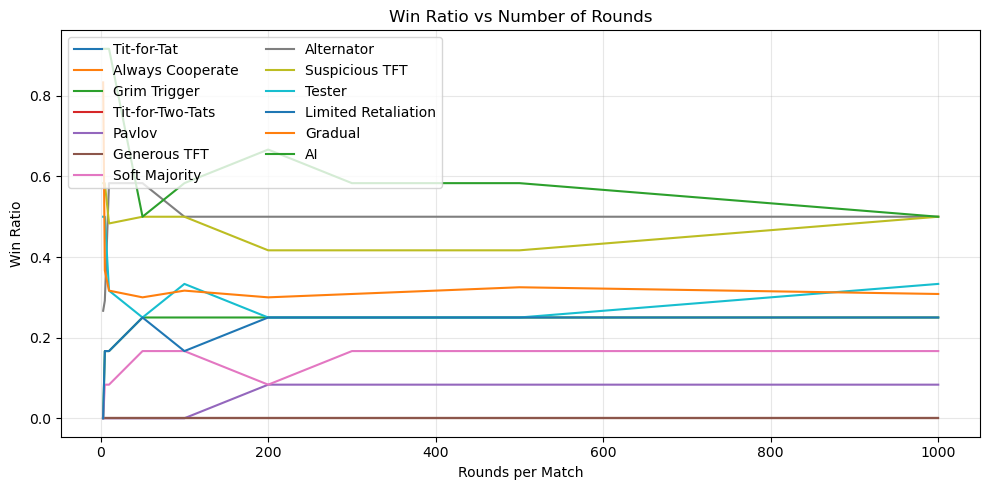

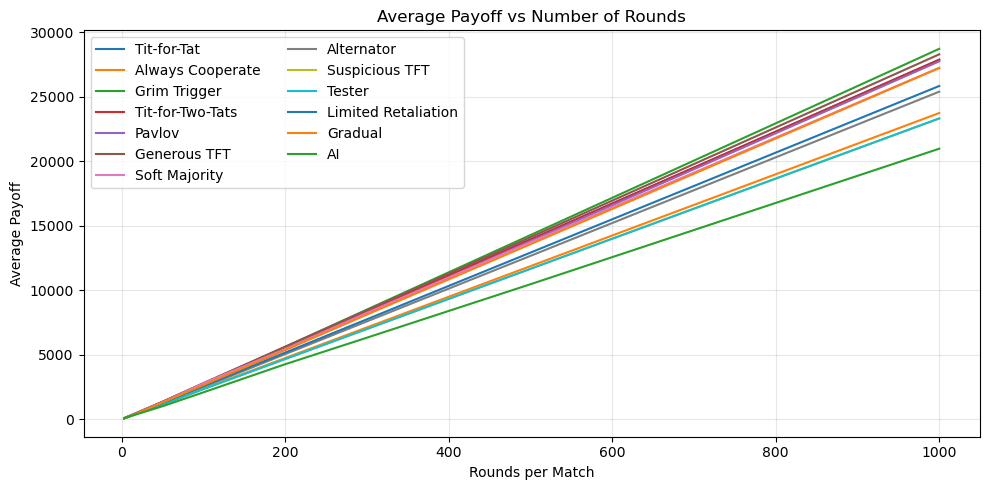

In [233]:
# --- Plot 1: Win Ratio vs Rounds per Match ---
plt.figure(figsize=(10, 5))
for s in STRATEGIES:
    plt.plot(rounds_list, win_ratios[s], label=s)
plt.xlabel('Rounds per Match')
plt.ylabel('Win Ratio')
plt.title('Win Ratio vs Number of Rounds')
plt.legend(loc='upper left', ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# --- Plot 2: Average Payoff vs Rounds per Match ---
plt.figure(figsize=(10, 5))
for s in STRATEGIES:
    plt.plot(rounds_list, avg_payoffs[s], label=s)
plt.xlabel('Rounds per Match')
plt.ylabel('Average Payoff')
plt.title('Average Payoff vs Number of Rounds')
plt.legend(loc='upper left', ncol=2)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [229]:
import joblib

joblib.dump(clf, 'policy.pkl')

['policy.pkl']